In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Preparation
# Define a transformation to convert images to tensors and normalize them to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean=0.5 and std=0.5
])

# Load CIFAR-10 training and test datasets with the defined transformation
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

# Create data loaders for batching and shuffling
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)




100%|██████████| 170M/170M [00:11<00:00, 14.7MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
# 2. Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder: Compress the input image into a latent representation
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),  # Downsample
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # Further downsample
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 128),  # Fully connected layer for latent representation
            nn.ReLU()
        )
        # Decoder: Reconstruct the image from the latent representation
        self.decoder = nn.Sequential(
            nn.Linear(128, 32 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (32, 8, 8)),  # Reshape to match the output of the encoder
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upsample
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # Final upsample
            nn.Tanh()  # Output values in range [-1, 1]
        )


    def forward(self, x):
        latent = self.encoder(x)  # Encode input to latent representation
        reconstruction = self.decoder(latent)  # Decode latent representation to reconstruct input
        return latent, reconstruction

# 3. Train the Autoencoder
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
model = Autoencoder().to(device)
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [3]:
def train_model(model, loader, criterion, optimizer, epochs=20):
    model.train()  # Set the model to training mode
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in loader:  # Loop through batches
            images = images.to(device)  # Move images to the device

            optimizer.zero_grad()  # Clear gradients from the previous step
            latent, reconstruction = model(images)  # Forward pass
            loss = criterion(reconstruction, images)  # Compute reconstruction loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            total_loss += loss.item()

        # Print average loss per epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(loader):.4f}")

# Train the autoencoder
train_model(model, train_loader, criterion, optimizer)

Epoch [1/20], Loss: 0.0698
Epoch [2/20], Loss: 0.0371
Epoch [3/20], Loss: 0.0335
Epoch [4/20], Loss: 0.0318
Epoch [5/20], Loss: 0.0309
Epoch [6/20], Loss: 0.0306
Epoch [7/20], Loss: 0.0303
Epoch [8/20], Loss: 0.0301
Epoch [9/20], Loss: 0.0300
Epoch [10/20], Loss: 0.0298
Epoch [11/20], Loss: 0.0297
Epoch [12/20], Loss: 0.0296
Epoch [13/20], Loss: 0.0296
Epoch [14/20], Loss: 0.0295
Epoch [15/20], Loss: 0.0294
Epoch [16/20], Loss: 0.0294
Epoch [17/20], Loss: 0.0293
Epoch [18/20], Loss: 0.0293
Epoch [19/20], Loss: 0.0292
Epoch [20/20], Loss: 0.0292


In [4]:
# 4. Extract Latent Vectors
# Function to extract latent vectors and corresponding images from the dataset
def extract_latent_vectors(model, loader):
    model.eval()  # Set the model to evaluation mode
    latent_vectors = []
    images_list = []
    with torch.no_grad():  # Disable gradient computation
        for images, _ in loader:
            images = images.to(device)  # Move images to the device
            latent, _ = model(images)  # Encode images to latent space
            latent_vectors.append(latent.cpu().numpy())  # Collect latent vectors
            images_list.append(images.cpu().numpy())  # Collect original images
    return np.concatenate(latent_vectors), np.concatenate(images_list)

latent_vectors, test_images = extract_latent_vectors(model, test_loader)


In [5]:

# 5. Find Similar Images
# Function to find the top-k most similar images to a query image
def find_similar_images(query_index, latent_vectors, images, top_k=5):
    query_vector = latent_vectors[query_index].reshape(1, -1)  # Get the latent vector for the query image
    similarities = cosine_similarity(query_vector, latent_vectors)[0]  # Compute cosine similarity
    top_indices = similarities.argsort()[-top_k-1:-1][::-1]  # Get indices of top-k most similar images
    return top_indices

query_idx = 0  # Example query index
top_indices = find_similar_images(query_idx, latent_vectors, test_images)


In [7]:
top_indices

array([9512, 9550, 5906, 6587, 3263])

In [8]:
# 6. Display Query and Results
# Function to display the query image and top-k similar images
def display_query_and_results(query_image, top_indices, test_images, top_k=5):
    plt.figure(figsize=(12, 6))
    # Display Query Image
    plt.subplot(1, top_k + 1, 1)
    plt.title("Query Image")
    plt.imshow((query_image.transpose(1, 2, 0) + 1) / 2)  # Unnormalize
    plt.axis('off')

    # Display Similar Images
    for i, idx in enumerate(top_indices):
        plt.subplot(1, top_k + 1, i + 2)
        plt.title(f"Similar {i+1}")
        plt.imshow((test_images[idx].transpose(1, 2, 0) + 1) / 2)  # Unnormalize
        plt.axis('off')
    plt.show()

In [10]:
# Example Usage:
def find_similar_from_dataset(query_index, model, latent_vectors, test_images, top_k=5):
    model.eval()  # Ensure model is in evaluation mode
    query_vector = latent_vectors[query_index].reshape(1, -1)  # Get latent vector for the query image
    similarities = cosine_similarity(query_vector, latent_vectors)[0]  # Compute cosine similarity
    top_indices = similarities.argsort()[-top_k-1:-1][::-1]  # Exclude the query image itself
    return top_indices, test_images[query_index]


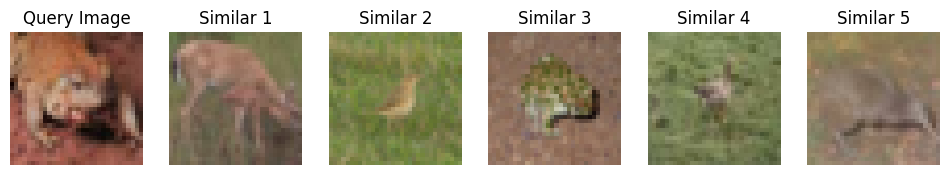

In [11]:
query_idx = 5  # Index of the image in the test dataset
top_k = 5      # Number of similar images to retrieve
top_indices, query_image = find_similar_from_dataset(query_idx, model, latent_vectors, test_images)
display_query_and_results(query_image, top_indices, test_images, top_k=top_k)

In [12]:
# 7. Evaluate Similarity Search
# Function to evaluate the similarity search performance using Precision, Recall, and Retrieval Accuracy
def evaluate_similarity_search(model, latent_vectors, test_loader, top_k=5):
    # Extract labels from the dataset
    labels = np.array(test_loader.dataset.targets)

    precision_scores = []
    recall_scores = []
    retrieval_accuracies = []

    for query_idx in range(len(latent_vectors)):
        # Find similar images
        query_vector = latent_vectors[query_idx].reshape(1, -1)
        similarities = cosine_similarity(query_vector, latent_vectors)[0]
        top_indices = similarities.argsort()[-top_k-1:-1][::-1]  # Exclude query itself

        # Get the true label for the query
        query_label = labels[query_idx]

        # Check relevance of retrieved images
        retrieved_labels = labels[top_indices]
        relevant_count = np.sum(retrieved_labels == query_label)  # Count relevant images in the top-k
        total_relevant = np.sum(labels == query_label)  # Total relevant images in the dataset

        # Precision@k
        precision = relevant_count / top_k
        precision_scores.append(precision)

        # Recall@k
        recall = relevant_count / total_relevant if total_relevant > 0 else 0
        recall_scores.append(recall)

        # Retrieval Accuracy
        retrieval_accuracy = 1 if relevant_count > 0 else 0
        retrieval_accuracies.append(retrieval_accuracy)

    # Aggregate metrics
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_accuracy = np.mean(retrieval_accuracies)

    print(f"Precision@{top_k}: {avg_precision:.4f}")
    print(f"Recall@{top_k}: {avg_recall:.4f}")
    print(f"Retrieval Accuracy@{top_k}: {avg_accuracy:.4f}")

    return avg_precision, avg_recall, avg_accuracy

# Example Usage:
evaluate_similarity_search(model, latent_vectors, test_loader, top_k=5)

Precision@5: 0.2725
Recall@5: 0.0014
Retrieval Accuracy@5: 0.6641


(0.27248000000000006, 0.0013624000000000002, 0.6641)